# Classification with TF2

In [3]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from imutils import paths
from sklearn.utils import shuffle

# LOAD DATASET

In [4]:
# parameters
batch_size = 32
target_size = (224, 224)
labels = {'trash': 5, 'glass': 1, 'plastic': 4, 'cardboard': 0, 'paper': 3, 'metal': 2}


#######################################################################################
#TRAIN
train_path =  '../datasets/dataset-resized/train'

x_train = []
train_labels = []

train_imagePaths = sorted(list(paths.list_images(train_path)))
#print(train_imagePaths)
for imagePath in train_imagePaths:
    #print(imagePath)
    img = cv2.imread(imagePath)
    #img = cv2.resize(img, target_size).flatten()
    img = cv2.resize(img, target_size)
    x_train.append(img)

    
    label = imagePath.split(os.path.sep)[-2]
    if label!='.ipynb_checkpoints':
    #print(train_labels)
    #if labels[label] not in train_labels:
    #    train_labels.append(labels[label])
        train_labels.append(labels[label])
        
x_train, train_labels = shuffle(x_train, train_labels)

print("len x_train", len(x_train))
print("x_train[0] shape", x_train[0].shape)
print("len train_labels", len(train_labels))

x_train = np.array(x_train, dtype="float") / 255.0
train_labels = np.array(train_labels)


#########################################################################
#TEST
test_path = '../datasets/dataset-resized/test'

x_test = []
test_labels = []


test_imagePaths = sorted(list(paths.list_images(test_path)))
#print(test_imagePaths)
for imagePath in test_imagePaths:
    #print(imagePath)
    img = cv2.imread(imagePath)
    #img = cv2.resize(img, target_size).flatten()
    img = cv2.resize(img, target_size)
    x_test.append(img)

    
    label = imagePath.split(os.path.sep)[-2]
    if label!='.ipynb_checkpoints':
    #if labels[label] not in test_labels:
    #    test_labels.append(labels[label])
        test_labels.append(labels[label])


x_test , test_labels = shuffle(x_test, test_labels)

print("len x_test", len(x_test))
print("x_test[0] shape", x_test[0].shape)
print("len test_labels", len(test_labels))

x_test = np.array(x_test, dtype="float") / 255.0
test_labels = np.array(test_labels)



########################################################################
#VAL
val_path = '../datasets/dataset-resized/val'

x_val = []
val_labels = []


val_imagePaths = sorted(list(paths.list_images(val_path)))
#print(val_imagePaths)

for imagePath in val_imagePaths:
    if '.ipynb_checkpoints' not in imagePath:
        #print(imagePath)
        img = cv2.imread(imagePath)
        #img = cv2.resize(img, target_size).flatten()
        img = cv2.resize(img, target_size)
        x_val.append(img)

    
    label = imagePath.split(os.path.sep)[-2]
    if label!='.ipynb_checkpoints':
    #if labels[label] not in val_labels:
    #    val_labels.append(labels[label])
        val_labels.append(labels[label])
    

x_val , val_labels = shuffle(x_val, val_labels)

print("len x_val", len(x_val))
print("x_val[0] shape", x_val[0].shape)
print("len val_labels", len(val_labels))

x_val = np.array(x_val, dtype="float") / 255.0
val_labels = np.array(val_labels)

len x_train 1770
x_train[0] shape (224, 224, 3)
len train_labels 1770
len x_test 429
x_test[0] shape (224, 224, 3)
len test_labels 429
len x_val 328
x_val[0] shape (224, 224, 3)
len val_labels 328


## Convert one_hot encoding to labels

In [5]:
num_classes = 6
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

# Define Metrics

In [6]:
def mcor(y_true, y_pred):
    #matthews_correlation
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    
    y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    
    tp = tf.keras.backend.sum(y_pos * y_pred_pos)
    tn = tf.keras.backend.sum(y_neg * y_pred_neg)
    
    fp = tf.keras.backend.sum(y_neg * y_pred_pos)
    fn = tf.keras.backend.sum(y_pos * y_pred_neg)
    
    numerator = (tp * tn - fp * fn)
    denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return numerator / (denominator + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

# Model (MobileNet{imagenet})

In [7]:
#Model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)

x = tf.keras.layers.GlobalAveragePooling2D(input_shape=model.output_shape[1:])(model.output)
x = tf.keras.layers.Dense(6, activation='softmax', kernel_initializer='glorot_normal')(x)
model = tf.keras.Model(inputs=model.input, outputs=x)

for layer in model.layers[:-1]:#[n_frozen_layers:]:
    layer.trainable=True

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv

In [9]:
checkpoints = []

if not os.path.exists('../logs/mobilenet_fine_tuning_trashnet/'):
    os.makedirs('../logs/mobilenet_fine_tuning_trashnet/')

checkpoints.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
checkpoints.append(tf.keras.callbacks.ModelCheckpoint(filepath='../models/mobilenet_fine_trashnet_120.h5', monitor='val_loss', save_best_only=True))

In [10]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy',mcor,recall, f1])

In [11]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=120, batch_size=batch_size,verbose=1, callbacks=checkpoints)

Train on 1770 samples, validate on 328 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/120
1770/1770 [==============================] - 16s 9ms/sample - loss: 1.8789 - acc: 0.2898 - mcor: 0.1455 - recall: 0.1287 - f1: 0.1909 - val_loss: 1.5218 - val_acc: 0.3902 - val_mcor: 0.2016 - val_recall: 0.1534 - val_f1: 0.2305
Epoch 2/120
1770/1770 [==============================] - 11s 6ms/sample - loss: 1.1735 - acc: 0.5367 - mcor: 0.4203 - recall: 0.3345 - f1: 0.4494 - val_loss: 1.1743 - val_acc: 0.5579 - val_mcor: 0.4088 - val_recall: 0.3182 - val_f1: 0.4327
Epoch 3/120
1770/1770 [==============================] - 10s 6ms/sample - loss: 0.9272 - acc: 0.6638 - mcor: 0.5585 - recall: 0.4673 - f1: 0.5879 - val_loss: 0.9720 - val_acc: 0.6646 - val_mcor: 0.5535 - val_recall: 0.4858 - val_f1: 0.5931
Epoch 4/120
1770/1770 [==============================] - 11s 6ms/sample - loss: 0.7683 - acc: 0.7249 - mcor: 0.6545 - recall: 0.5800 - f1: 0.6862 - val_loss: 0.8446 - val_acc: 0.7104 - 

# SAVE WEIGHTS

In [15]:
model.save_weights('../models/mobilenet_fine_trashnet_last_weights.h5')

# Draw Chart - Val Acc & Val Loss

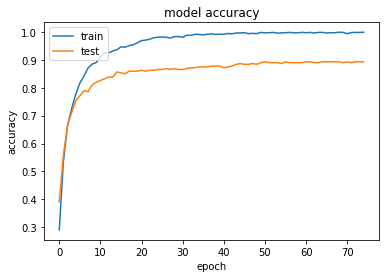

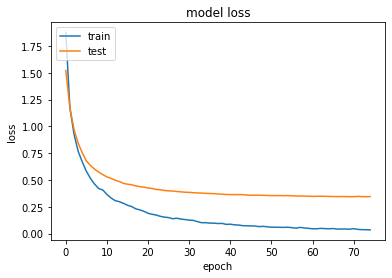

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RESULTS

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

## EVALUATING - TEST

In [20]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

429/429 [==============================] - 1s 1ms/sample - loss: 0.3305 - acc: 0.8695 - mcor: 0.8588 - recall: 0.8529 - f1: 0.8807
Test score: 0.3304658137557112
Test accuracy: 0.86946386


## Confusion Matrix - TEST

In [24]:
y_pred = model.predict(x_test) 
y_pred = np.argmax(y_pred, axis=1)
y_true =np.argmax(y_test, axis=1)

target_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Compute a confusion matrix and a normalised confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm)

# Print a classification report, including precision, recall, and f1-score.
print(classification_report(y_true, y_pred, target_names=target_names)) 

[[63  0  0  8  0  0]
 [ 0 74  5  0  3  0]
 [ 0  6 67  3  2  0]
 [ 1  1  0 89  0  0]
 [ 0  6  8  5 62  0]
 [ 1  0  2  3  2 18]]
              precision    recall  f1-score   support

   cardboard       0.97      0.89      0.93        71
       glass       0.85      0.90      0.88        82
       metal       0.82      0.86      0.84        78
       paper       0.82      0.98      0.89        91
     plastic       0.90      0.77      0.83        81
       trash       1.00      0.69      0.82        26

    accuracy                           0.87       429
   macro avg       0.89      0.85      0.86       429
weighted avg       0.88      0.87      0.87       429



## EVALUATING - VAL

In [25]:
score = model.evaluate(x_val, y_val)
print('VAL score:', score[0])
print('VAL accuracy:', score[1])

328/328 [==============================] - 0s 1ms/sample - loss: 0.3454 - acc: 0.8933 - mcor: 0.8638 - recall: 0.8750 - f1: 0.8859
VAL score: 0.3453683656890218
VAL accuracy: 0.89329267


## Confusion Matrix - VAL

In [27]:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_true =np.argmax(y_val, axis=1)

target_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Compute a confusion matrix and a normalised confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm)

# Print a classification report, including precision, recall, and f1-score.
print(classification_report(y_true, y_pred, target_names=target_names)) 

[[51  0  1  2  0  0]
 [ 0 62  2  1  1  0]
 [ 0  1 42  0  2  0]
 [ 1  0  1 81  0  2]
 [ 0  7  0  3 47  1]
 [ 1  0  2  4  3 10]]
              precision    recall  f1-score   support

   cardboard       0.96      0.94      0.95        54
       glass       0.89      0.94      0.91        66
       metal       0.88      0.93      0.90        45
       paper       0.89      0.95      0.92        85
     plastic       0.89      0.81      0.85        58
       trash       0.77      0.50      0.61        20

    accuracy                           0.89       328
   macro avg       0.88      0.85      0.86       328
weighted avg       0.89      0.89      0.89       328

